## Building a  forecasting model

In [10]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout    

In [26]:
tsla = pd.read_csv("../data/processed/TSLA_processed.csv")

In [28]:
tsla['Date'] = pd.to_datetime(tsla['Date'], format="mixed")
tsla['Date'].sort_values(ascending=True)
tsla.set_index('Date', inplace=True)

In [5]:
tsla_return = tsla['daily_percentage']
train_len = 0.8 # 80%
train_size = int(len(tsla_return)*train_len)
train_data, test_data = tsla_return[0:train_size], tsla_return[train_size:len(tsla_return)]
train_arima = train_data.values
test_arima = test_data.values
arima_order = (5, 1, 1)
model_arima = ARIMA(train_arima, order=arima_order)
model_arima_fit = model_arima.fit()
print("ARIMA model trained.")
print(model_arima_fit.summary()) # Print model summary for details

ARIMA model trained.
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1876
Model:                 ARIMA(5, 1, 1)   Log Likelihood                3506.091
Date:                Tue, 12 Aug 2025   AIC                          -6998.182
Time:                        18:35:40   BIC                          -6959.427
Sample:                             0   HQIC                         -6983.905
                               - 1876                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0034      0.019      0.173      0.863      -0.035       0.041
ar.L2          0.0772      0.016      4.693      0.000       0.045       0.109
ar.L3         -0.0200      0.01

/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [7]:
history_arima = [x for x in train_arima]
predictions_arima = []

print("\nMaking predictions with ARIMA model...")
for t in range(len(test_arima)):
    model = ARIMA(history_arima, order=arima_order)
    model_fit = model.fit()
    output = model_fit.forecast() # Forecast the next value
    yhat = output[0]
    predictions_arima.append(yhat)
    obs = test_arima[t]
    history_arima.append(obs) # Add actual observation to history for next prediction

# Evaluate ARIMA performance
rmse_arima = np.sqrt(mean_squared_error(test_arima, predictions_arima))
print(f'ARIMA RMSE: {rmse_arima:.4f}')

# Plot ARIMA predictions vs. actual



Making predictions with ARIMA model...


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mikiask/anotherproject/Time-Series-Forecasting-fo

ARIMA RMSE: 0.0402


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


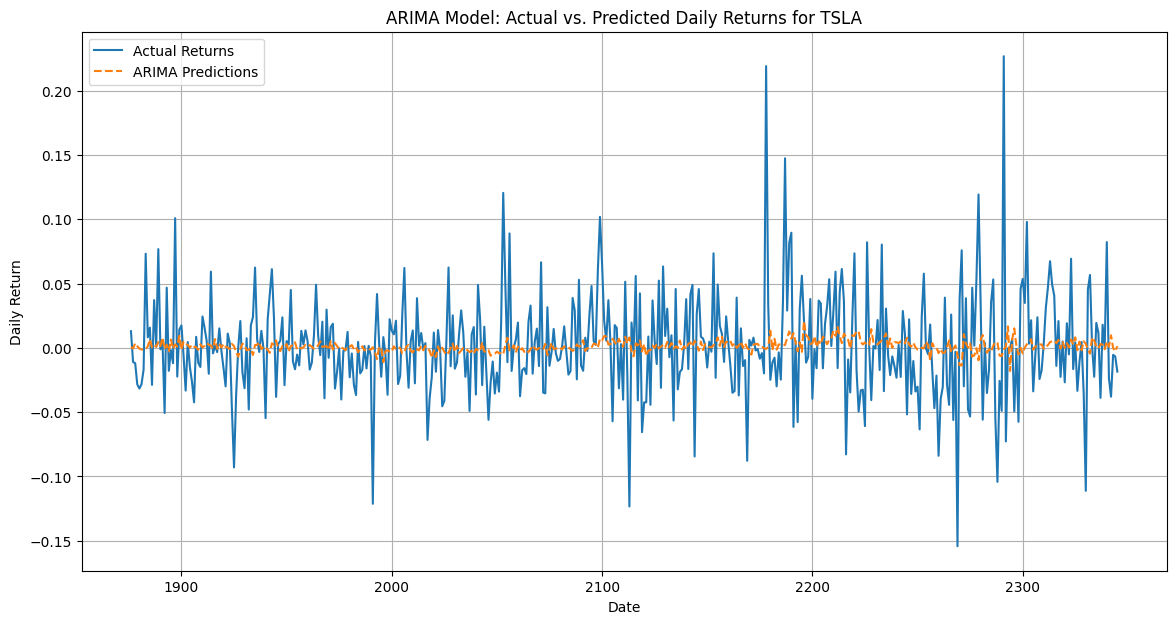

In [8]:
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data.values, label='Actual Returns')
plt.plot(test_data.index, predictions_arima, label='ARIMA Predictions', linestyle='--')
plt.title(f'ARIMA Model: Actual vs. Predicted Daily Returns for TSLA')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
def create_sequences_lstm(data, time_step):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0] # features for time_step
        X.append(a)
        Y.append(data[i + time_step, 0]) # target value
    return np.array(X), np.array(Y)

time_step = 60

In [13]:
scale = MinMaxScaler(feature_range=(0,1))
scaled_data = scale.fit_transform(tsla_return.values.reshape(-1,1))

train_scaled = scaled_data[0:train_size, :]
test_scaled = scaled_data[train_size:len(tsla_return),:]

X_train, y_train = create_sequences_lstm(train_scaled, time_step)
X_test, y_test = create_sequences_lstm(test_scaled, time_step)


LSTM X_train shape: (1815, 60)
LSTM X_test shape: (409, 60)

Building LSTM model...


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training LSTM model...
Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.0123
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0058
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0057
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0057
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.0057
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0053
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0056
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0054
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0055
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0054
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0054
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0053
Epoch 13/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0053
Epoch 14/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0052
Epoch 15/100
57/57 ━━━━━━━━━━━━

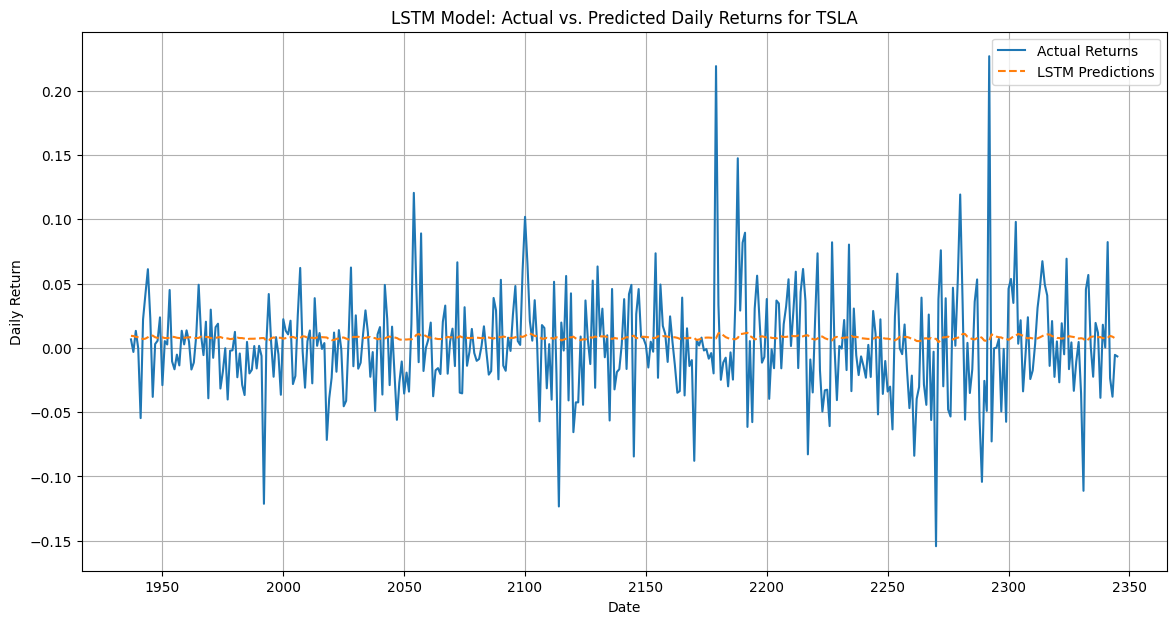

In [ ]:
print(f"\nLSTM X_train shape: {X_train.shape}")
print(f"LSTM X_test shape: {X_test.shape}")

# Build the LSTM model
print("\nBuilding LSTM model...")
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1))) # First LSTM layer
model_lstm.add(Dropout(0.2)) # Dropout for regularization
model_lstm.add(LSTM(units=50, return_sequences=False)) # Second LSTM layer
model_lstm.add(Dropout(0.2)) # Another dropout layer
model_lstm.add(LSTM(units=50, return_sequences=False)) # Second LSTM layer
model_lstm.add(Dropout(0.2)) # Another dropout layer
model_lstm.add(Dense(units=1)) # Output layer for single prediction

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

print("Training LSTM model...")
# Fit the model
# Using verbose=1 to see training progress
model_lstm.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

print("LSTM model trained.")

# Make predictions
print("\nMaking predictions with LSTM model...")
predictions_lstm_scaled = model_lstm.predict(X_test)

# Inverse transform the predictions to original scale
predictions_lstm = scale.inverse_transform(predictions_lstm_scaled)

# Inverse transform y_test to original scale for comparison
y_test_actual = scale.inverse_transform(y_test.reshape(-1, 1))

# Evaluate LSTM performance
# Ensure y_test_actual and predictions_lstm have the same number of elements
min_len = min(len(y_test_actual), len(predictions_lstm))
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual[:min_len], predictions_lstm[:min_len]))
print(f'LSTM RMSE: {rmse_lstm:.4f}')

# Plot LSTM predictions vs. actual
# Adjust test_data index to match the length of predictions
plot_start_index = len(train_data) + time_step + 1 # Adjust for look-back window
plot_indices = tsla_return.index[plot_start_index : plot_start_index + min_len]


plt.figure(figsize=(14, 7))
plt.plot(plot_indices, y_test_actual[:min_len], label='Actual Returns')
plt.plot(plot_indices, predictions_lstm[:min_len], label='LSTM Predictions', linestyle='--')
plt.title(f'LSTM Model: Actual vs. Predicted Daily Returns for TSLA')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
import warnings
# Assuming 'train_data' and 'test_data' are prepared as in your Canvas
# Convert to numpy arrays if not already
train_arima = train_data.values
test_arima = test_data.values
    
# Define the p, d, q ranges to search
p_values = range(0, 5) # Example: 0, 1, 2
d_values = [0,1]        # d is 0 for stationary daily returns
q_values = range(0, 5) # Example: 0, 1, 2

best_rmse = float('inf')
best_order = None

print("Starting Grid Search for ARIMA parameters...")

# Suppress warnings during the grid search for cleaner output
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    for p in p_values:
        for d in d_values: # d will likely be 0 for daily returns
            for q in q_values:
                order = (p, d, q)
                try:
                    # Fit model
                    model = ARIMA(train_arima, order=order)
                    model_fit = model.fit() # Increase maxiter to aid convergence

                    # Make predictions (simple one-step ahead forecasting)
                    history = [x for x in train_arima]
                    predictions = []
                    for t in range(len(test_arima)):
                        model = ARIMA(history, order=order)
                        model_fit = model.fit() # Need to fit repeatedly for walk-forward
                        yhat = model_fit.forecast()[0]
                        predictions.append(yhat)
                        history.append(test_arima[t])

                    # Evaluate performance
                    rmse = np.sqrt(mean_squared_error(test_arima, predictions))

                    # Update best model if current one is better
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_order = order
                    print(f'ARIMA{order} RMSE: {rmse:.4f}')

                except Exception as e:
                    print(f'ARIMA{order} failed: {e}') #         Uncomment to see specific errors
                    continue # Skip to the next combination if fitting fails

print(f"\nGrid Search Complete. Best ARIMA Order: {best_order} with RMSE: {best_rmse:.4f}")

Starting Grid Search for ARIMA parameters...
ARIMA(0, 0, 0) RMSE: 0.0432
ARIMA(0, 0, 1) RMSE: 0.0432
ARIMA(0, 0, 2) RMSE: 0.0431
ARIMA(0, 0, 3) RMSE: 0.0432
ARIMA(0, 0, 4) RMSE: 0.0432
ARIMA(0, 1, 0) RMSE: 0.0607
ARIMA(0, 1, 1) RMSE: 0.0432
ARIMA(0, 1, 2) RMSE: 0.0432
ARIMA(0, 1, 3) RMSE: 0.0431
ARIMA(0, 1, 4) RMSE: 0.0432
ARIMA(1, 0, 0) RMSE: 0.0432


KeyboardInterrupt: 

In [ ]:
param_grid = {
    'time_step': [20, 30, 40], # Look-back window
    'units': [32, 50, 64],     # Number of LSTM units in the first layer
    'epochs': [50, 100],       # Number of training epochs
    'batch_size': [16, 32]     # Batch size for training
}

best_rmse = float('inf')
best_params = {}
results = []

print("Starting LSTM Hyperparameter Grid Search...\n")

# Iterate through all combinations in the grid
for time_step in param_grid['time_step']:
    for units in param_grid['units']:
        for epochs in param_grid['epochs']:
            for batch_size in param_grid['batch_size']:
                current_params = {
                    'time_step': time_step,
                    'units': units,
                    'epochs': epochs,
                    'batch_size': batch_size
                }
                print(f"Testing params: {current_params}")

                # Split data into training and testing sets based on current time_step
                # Ensure enough data points for the time_step
                if len(tsla_return) < time_step + 1:
                    print(f"  Skipping: Not enough data for time_step {time_step}")
                    continue

                train_size = int(len(tsla_return) * 0.8)
                
                # Adjust train_data and test_data based on time_step requirement for sequence creation
                # The train data needs to include enough points for the last sequence of the training set
                # and the test data needs enough for its first prediction.
                # A common approach is to split the *raw* returns, then create sequences.
                
                # Scaling needs to be done on the full dataset before splitting for consistency
                scaler = MinMaxScaler(feature_range=(0, 1))
                scaled_returns = scaler.fit_transform(tsla_return.values.reshape(-1, 1))

                # Create sequences for the *entire* scaled dataset first
                X_full, y_full = create_sequences_lstm(scaled_returns, time_step)
                
                # Check if enough sequences could be created
                if X_full.shape[0] == 0:
                    print(f"  Skipping: Not enough data after sequence creation for time_step {time_step}")
                    continue

                # Split sequences into train and test
                train_split_idx = int(X_full.shape[0] * 0.8)
                X_train, X_test = X_full[:train_split_idx], X_full[train_split_idx:]
                y_train, y_test = y_full[:train_split_idx], y_full[train_split_idx:]

                # Reshape input for LSTM
                X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
                X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

                if X_train.shape[0] == 0 or X_test.shape[0] == 0:
                    print(f"  Skipping: Train or test set is empty after splitting sequences for time_step {time_step}")
                    continue

                # Build the LSTM model
                model_lstm = Sequential()
                model_lstm.add(LSTM(units=units, return_sequences=True, input_shape=(time_step, 1)))
                model_lstm.add(Dropout(0.2))
                model_lstm.add(LSTM(units=units // 2, return_sequences=False)) # Use half units in second layer
                model_lstm.add(Dropout(0.2))
                model_lstm.add(Dense(units=1))
                model_lstm.compile(optimizer='adam', loss='mean_squared_error')

                # Train the model
                try:
                    history = model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
                except Exception as e:
                    print(f"  Training failed for these params: {e}. Skipping.")
                    continue

                # Make predictions
                predictions_lstm_scaled = model_lstm.predict(X_test, verbose=0)

                # Inverse transform predictions and actuals
                predictions_lstm = scaler.inverse_transform(predictions_lstm_scaled)
                y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

                # Evaluate performance (RMSE)
                current_rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_lstm))
                results.append({'params': current_params, 'rmse': current_rmse})

                print(f"  RMSE: {current_rmse:.4f}")

                # Check for best model
                if current_rmse < best_rmse:
                    best_rmse = current_rmse
                    best_params = current_params
                    print(f"  New best RMSE found: {best_rmse:.4f} with params: {best_params}")

print("\n--- Grid Search Complete ---")
print(f"Best RMSE: {best_rmse:.4f}")
print(f"Best Parameters: {best_params}")

# Optional: Sort results for review
results_df = pd.DataFrame(results).sort_values(by='rmse')
print("\nAll Results (sorted by RMSE):")
print(results_df)

Starting LSTM Hyperparameter Grid Search...

Testing params: {'time_step': 20, 'units': 32, 'epochs': 50, 'batch_size': 16}


E0000 00:00:1754992971.687537  442099 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1754992971.709228  442099 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0432
  New best RMSE found: 0.0432 with params: {'time_step': 20, 'units': 32, 'epochs': 50, 'batch_size': 16}
Testing params: {'time_step': 20, 'units': 32, 'epochs': 50, 'batch_size': 32}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0432
  New best RMSE found: 0.0432 with params: {'time_step': 20, 'units': 32, 'epochs': 50, 'batch_size': 32}
Testing params: {'time_step': 20, 'units': 32, 'epochs': 100, 'batch_size': 16}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0431
  New best RMSE found: 0.0431 with params: {'time_step': 20, 'units': 32, 'epochs': 100, 'batch_size': 16}
Testing params: {'time_step': 20, 'units': 32, 'epochs': 100, 'batch_size': 32}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0432
Testing params: {'time_step': 20, 'units': 50, 'epochs': 50, 'batch_size': 16}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0431
  New best RMSE found: 0.0431 with params: {'time_step': 20, 'units': 50, 'epochs': 50, 'batch_size': 16}
Testing params: {'time_step': 20, 'units': 50, 'epochs': 50, 'batch_size': 32}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0432
Testing params: {'time_step': 20, 'units': 50, 'epochs': 100, 'batch_size': 16}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0432
Testing params: {'time_step': 20, 'units': 50, 'epochs': 100, 'batch_size': 32}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0431
Testing params: {'time_step': 20, 'units': 64, 'epochs': 50, 'batch_size': 16}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0432
Testing params: {'time_step': 20, 'units': 64, 'epochs': 50, 'batch_size': 32}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0432
Testing params: {'time_step': 20, 'units': 64, 'epochs': 100, 'batch_size': 16}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0432
Testing params: {'time_step': 20, 'units': 64, 'epochs': 100, 'batch_size': 32}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0432
Testing params: {'time_step': 30, 'units': 32, 'epochs': 50, 'batch_size': 16}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0431
  New best RMSE found: 0.0431 with params: {'time_step': 30, 'units': 32, 'epochs': 50, 'batch_size': 16}
Testing params: {'time_step': 30, 'units': 32, 'epochs': 50, 'batch_size': 32}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0432
Testing params: {'time_step': 30, 'units': 32, 'epochs': 100, 'batch_size': 16}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0432
Testing params: {'time_step': 30, 'units': 32, 'epochs': 100, 'batch_size': 32}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0431
  New best RMSE found: 0.0431 with params: {'time_step': 30, 'units': 32, 'epochs': 100, 'batch_size': 32}
Testing params: {'time_step': 30, 'units': 50, 'epochs': 50, 'batch_size': 16}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0430
  New best RMSE found: 0.0430 with params: {'time_step': 30, 'units': 50, 'epochs': 50, 'batch_size': 16}
Testing params: {'time_step': 30, 'units': 50, 'epochs': 50, 'batch_size': 32}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0432
Testing params: {'time_step': 30, 'units': 50, 'epochs': 100, 'batch_size': 16}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0431
Testing params: {'time_step': 30, 'units': 50, 'epochs': 100, 'batch_size': 32}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0431
Testing params: {'time_step': 30, 'units': 64, 'epochs': 50, 'batch_size': 16}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0432
Testing params: {'time_step': 30, 'units': 64, 'epochs': 50, 'batch_size': 32}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0431
Testing params: {'time_step': 30, 'units': 64, 'epochs': 100, 'batch_size': 16}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0431
Testing params: {'time_step': 30, 'units': 64, 'epochs': 100, 'batch_size': 32}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0432
Testing params: {'time_step': 40, 'units': 32, 'epochs': 50, 'batch_size': 16}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0432
Testing params: {'time_step': 40, 'units': 32, 'epochs': 50, 'batch_size': 32}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0431
Testing params: {'time_step': 40, 'units': 32, 'epochs': 100, 'batch_size': 16}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0433
Testing params: {'time_step': 40, 'units': 32, 'epochs': 100, 'batch_size': 32}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  RMSE: 0.0431
Testing params: {'time_step': 40, 'units': 50, 'epochs': 50, 'batch_size': 16}


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
#  Clean up predictions in case of NaNs for metric calculation
arima_predictions = np.array(predictions_arima)
# Align actuals and predictions by removing NaNs from both
valid_indices_arima = ~np.isnan(arima_predictions)
test_arima_clean = test_arima[valid_indices_arima]
arima_predictions_clean = arima_predictions[valid_indices_arima]


# Calculate metrics for ARIMA model
arima_rmse = np.sqrt(mean_squared_error(test_arima_clean, arima_predictions_clean))
arima_mae = mean_absolute_error(test_arima_clean, arima_predictions_clean)
# MAPE calculation: avoid division by zero
arima_mape = np.mean(np.abs((test_arima_clean - arima_predictions_clean) / test_arima_clean)) * 100
arima_mape = arima_mape if not np.isinf(arima_mape) else np.nan

print(f"ARIMA Model Metrics (Test Set Period):")
print(f"  RMSE: {arima_rmse:.4f}")
print(f"  MAE: {arima_mae:.4f}")
print(f"  MAPE: {arima_mape:.4f}%") 

ARIMA Model Metrics (Test Set Period):
  RMSE: 0.0402
  MAE: 0.0290
  MAPE: 157.9864%


In [19]:
full_history_arima = tsla_return.values
model_arima_full = ARIMA(full_history_arima, order=arima_order)
model_arima_full_fit = model_arima_full.fit()

/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
forecast_horizon_days = 252 # Approximately 1 year of trading days (for 6-12 months)
confidence_level_alpha = 0.05 # 

In [21]:
arima_forecast_results = model_arima_full_fit.forecast(steps=forecast_horizon_days, alpha=confidence_level_alpha)
arima_future_predictions = arima_forecast_results[0]
arima_conf_int = arima_forecast_results[2] # This contains lower and upper bounds

/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


2025-10-10
DatetimeIndex(['2025-10-13', '2025-10-14', '2025-10-15', '2025-10-16',
               '2025-10-17', '2025-10-20', '2025-10-21', '2025-10-22',
               '2025-10-23', '2025-10-24',
               ...
               '2026-09-16', '2026-09-17', '2026-09-18', '2026-09-21',
               '2026-09-22', '2026-09-23', '2026-09-24', '2026-09-25',
               '2026-09-28', '2026-09-29'],
              dtype='datetime64[ns]', length=252, freq='B')


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


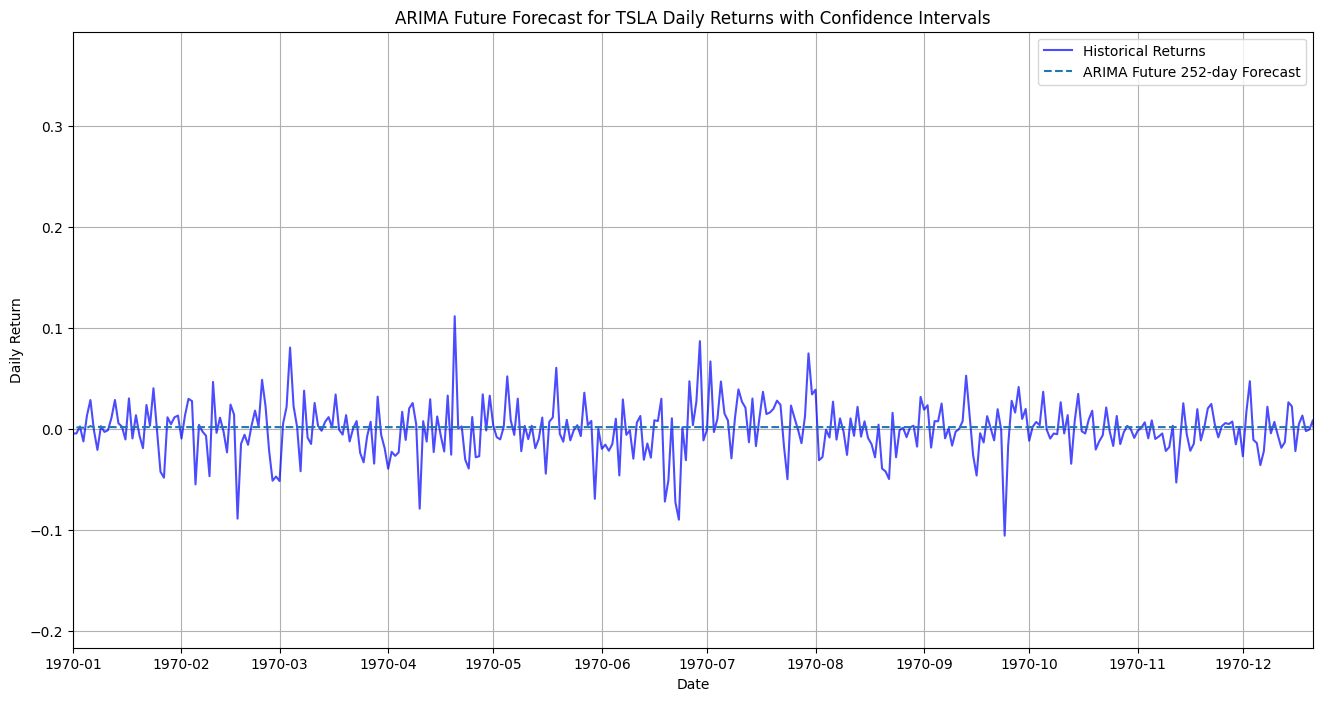

In [ ]:
last_date_in_data = tsla_return.index[-1]
print(last_date_in_data)
future_dates_arima = pd.date_range(start=last_date_in_data, periods=forecast_horizon_days + 1, freq='B')[1:] # 'B' for business day
print(future_dates_arima)
arima_forecast_results = model_arima_full_fit.forecast(steps=forecast_horizon_days, alpha=confidence_level_alpha)
arima_future_predictions = arima_forecast_results
arima_conf_int = arima_forecast_results[2] # This contains lower and upper bounds

# --- Robustness check for plotting: Ensure forecast length matches expected horizon ---
# If the forecast length doesn't match the expected horizon, it implies an issue
# with the model or data, but we adjust the plotting range to avoid ValueError.
if len(arima_future_predictions) != forecast_horizon_days:
    print(f"Warning: ARIMA forecast returned {len(arima_future_predictions)} steps, expected {forecast_horizon_days}. Adjusting plot range.")
    forecast_horizon_days_actual = len(arima_future_predictions)
    future_dates_arima = pd.date_range(start=last_date_in_data, periods=forecast_horizon_days_actual + 1, freq='B')[1:]
    arima_conf_int = arima_conf_int[:forecast_horizon_days_actual] # Truncate confidence interval if needed

# Create future dates index
last_date_in_data = tsla_return.index[-1]
future_dates_arima = pd.date_range(start=last_date_in_data, periods=forecast_horizon_days + 1, freq='B')[1:] # 'B' for business day

plt.figure(figsize=(16, 8))
plt.plot(tsla_return.index, tsla_return.values, label='Historical Returns', color='blue', alpha=0.7)
plt.plot(future_dates_arima, arima_future_predictions, label=f'ARIMA Future {forecast_horizon_days}-day Forecast', linestyle='--')
# plt.fill_between(future_dates_arima, arima_conf_int[:, 0], arima_conf_int[:, 1], color='green', alpha=0.2, label='95% Confidence Interval (ARIMA)')
plt.title(f'ARIMA Future Forecast for TSLA Daily Returns with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(True)
plt.xlim(tsla_return.index.min(), future_dates_arima.max()) # Ensure full x-axis range
plt.show()